<h1>Let's predict (or not) the Mean terrestrial temperature</h1>
<center><img src="./Images/MeanTempGISSTemp.png" width="300" align="center"></center> 

# Purpose
The GISS Surface Temperature Analysis ver. 4 (GISTEMP v4) is an estimate of global surface temperature change. We will try to predict the future of the data using some basic recural neural networks. 

# Dataset
We will assess how good (or not) a NN is able to predict the evolution of a dynamical system. The data set is the globak mean temperature with respect to 1976 from the global component of Climate at a Glance (GCAG).
    
# Work to do on this dataset
The goal is to let you discover how to make some "predictions" using recurrent neural networks like LSTMs.
We invite you to execute the cells, to play with the models, to change the number of layers, to compare the results... 


The contains two kind of temperatures, the GISS Surface Temperature Analysis (GISTEMP v4) and the the global component of Climate at a Glance (GCAG). See https://data.giss.nasa.gov/gistemp/ and https://www.ncdc.noaa.gov/cag/global/background.


# Let's load the data 

In [ ]:
%reset -f
import os
import warnings

import math
import random
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.python.keras.optimizers import Adam

warnings.filterwarnings('ignore')

[autoreload of numpy.core failed: Traceback (most recent call last):
  File "/Users/seydoux/anaconda3/envs/eds/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/seydoux/anaconda3/envs/eds/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    if not append_obj(module, old_objects, name, obj):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/seydoux/anaconda3/envs/eds/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 423, in append_obj
    in_module = hasattr(obj, "__module__") and obj.__module__ == module.__name__
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/seydoux/anaconda3/envs/eds/lib/python3.11/site-packages/numpy/core/defchararray.py", line 2, in __getattr__
    from numpy._core import defchararray
  File "/Users/seydoux/anaconda3/envs/eds/lib/python3.11/site-packages/numpy/_core/defchararray.py", li

In [2]:
DATA_DIR = "./Dataset"
TEMP_FILE = "GCAG/GCAG.csv"

df_alldata = pd.read_csv(os.path.join(DATA_DIR, TEMP_FILE))

## Classical commands to look at the data

In [3]:
display(df_alldata.head())

Source        Date    Mean
0     GCAG  2016-12-06  0.7895
1  GISTEMP  2016-12-06  0.8100
2     GCAG  2016-11-06  0.7504
3  GISTEMP  2016-11-06  0.9300
4     GCAG  2016-10-06  0.7292

In [4]:
display(df_alldata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Source  3288 non-null   object 
 1   Date    3288 non-null   object 
 2   Mean    3288 non-null   float64
dtypes: float64(1), object(2)
memory usage: 77.2+ KB


None

In [5]:
display(df_alldata["Source"].value_counts())

GCAG       1644
GISTEMP    1644
Name: Source, dtype: int64

## Create a subset of data

In the following, we will only keep the GISTEMP data. So we are taking a subset

In [6]:
df_gistemp = df_alldata[df_alldata["Source"].isin(["GISTEMP"])] # Let's grab the GISTEMP values only.
df_gistemp["Datetime"] = pd.to_datetime(df_gistemp['Date'])

series = df_gistemp["Mean"].to_numpy()
time =  df_gistemp["Datetime"].to_numpy()

In [7]:
display(df_gistemp.head())

Source        Date  Mean   Datetime
1  GISTEMP  2016-12-06  0.81 2016-12-06
3  GISTEMP  2016-11-06  0.93 2016-11-06
5  GISTEMP  2016-10-06  0.89 2016-10-06
7  GISTEMP  2016-09-06  0.87 2016-09-06
9  GISTEMP  2016-08-06  0.98 2016-08-06

## Smooth the data
It can be convenient to have a smooth reprensentation off the data. Here, we propose de moving average
In the next cell, we choose 20 days smoothing. Try yourself to see the effect of different values.

### ******* TO DO *********
Play with the following cells to modify the smoothing of the data. 
Pandas offers a quit convenient way to do it. 

Don't hesitate to have a look on the documentation [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)

In [8]:
win_size = 100
smoothTemp = df_gistemp['Mean'].rolling(win_size).mean()

In [9]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df_gistemp["Datetime"], df_gistemp["Mean"],
        label="Temp", alpha=0.7, color='k', lw=.7)
ax.plot(df_gistemp["Datetime"], smoothTemp, 'r-', 
        label="Smoothed", lw=1)
ax.set_xlabel('Year')
ax.set_ylabel('Delta T [C]')
ax.grid(True)
ax.legend()
plt.title("GISTEMP v4 dataset: Global Mean Estimates based on Land and Ocean Data")
plt.show()

# How to prepare data for Deep Learning module ?

As with any other ML/DL problem, we have to divide our data into `features` and `labels`. In this case our feature is effectively a number of values in the series,
with our label being the next value. We'll call that number of values that will treat as our feature, the window size, where we're taking a window of the data and training an ML model to predict the next value.
So for example, if we take our time series data, say, 30 days at a time, we'll use 30 values as the feature and the next value is the label. Then over time, we'll train a neural network to match the 30 features to the single label. 

## Split the data

Don't modify any of these functions. They will be necessary to prepare the dataset to feed the LSTMs.
Concerning the function `windowed_dataset`, one can have more detail with the bonus at the end of this notebook.

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Function which takes in a data series along with the parameters 
    for the size of the window that we want. The size of the batches 
    to use when training, and the size of the shuffle buffer, which 
    determines how the data will be shuffled. 
    
    """
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
    
def plot_series(time, series, format="-", start=0, end=None, label=""):
    """
    Tiny function to plot the data
    """
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def model_forecast(model, series, window_size):
    """
    Function to estimate the forecast according to the fitted model
    
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
rate_split = 0.25
window_size = 20
batch_size = 32
shuffle_buffer_size = 500

split_time = math.floor(rate_split*len(df_gistemp["Datetime"]))
time_train = df_gistemp["Datetime"][:split_time]
x_train = df_gistemp["Mean"][:split_time]
time_valid = df_gistemp["Datetime"][split_time:]
x_valid = df_gistemp["Mean"][split_time:]

print(f"x_train.shape: {x_train.shape}")
print(f"time_train.shape: {time_train.shape}")
print(f"x_valid.shape: {x_valid.shape}")
print(f"time_valid.shape: {time_valid.shape}")

x_train.shape: (411,)
time_train.shape: (411,)
x_valid.shape: (1233,)
time_valid.shape: (1233,)


## Plot the validation set and the training set

In [12]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(time_train, x_train,
        label="Training set")
ax.plot(time_valid, x_valid, 'r-', 
        label="Validation set")
ax.set_xlabel('Year')
ax.set_ylabel('Delta T [C]')
ax.grid(True)
ax.legend()
plt.title("GISTEMP v4 dataset: Global Mean Estimates based on Land and Ocean Data")
plt.show()

# Feed a single layer neural network

We can start training neural networks with our dataset.
First, a plain RNN with two layers.

## Implement the model


In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=32, 
                           shuffle_buffer=shuffle_buffer_size)
print(dataset)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 1]),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 50)
])

2022-01-26 10:53:57.967896: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          4352      
_________________________________________________________________
dense (Dense)                (None, None, 30)          990       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           31        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 5,373
Trainable params: 5,373
Non-trainable params: 0
_________________________________________________________________


In [15]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

The previous fit gives an example of the way to try several learning rates using a callback.
`lr_schedule` is an array of value to be "tried" during the fit.
After the fit, it's convenient to plot the loss in function the learning rate.

## Train the model

In [16]:
history = model.fit(dataset, epochs=80, 
                    callbacks=[lr_schedule], verbose=0)

2022-01-26 10:53:58.729823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


## Plot the evolution of the learning rate
This plot is often interesting to adjust the learning rate. If for example, your loss is increasing again after a while, one can select the range of learning rate to avoid this

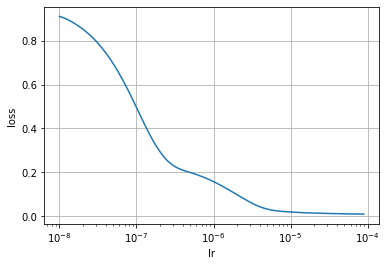

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel("lr");plt.ylabel("loss");plt.grid(True)

## Plot MAE and the Loss

Text(0.5, 1.0, 'MAE and Loss')

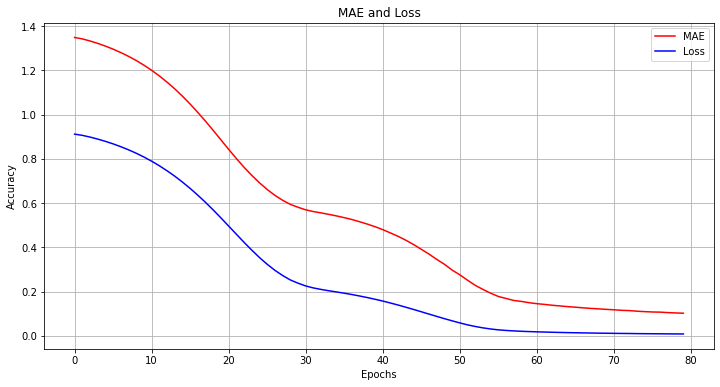

In [18]:
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(epochs, mae, 'r')
ax.plot(epochs, loss, 'b')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend(["MAE", "Loss"])
ax.grid(True)
plt.title('MAE and Loss')

In [19]:
lstm_forecast = model_forecast(model, series[..., np.newaxis], window_size)
lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)

# Bidirectionnal LSTM

Bidirectional long-short term memory (bi-lstm) is the process of making any neural network to have the sequence information in both directions backwards (future to past) or forward (past to future). 

In the sentence "Boys go to ......", we can not fill the blank space. Still, when we have a future sentence “Boys come out of school”, we can easily predict the past blank space the similar thing we want to perform by our model. Bi-LSTM allow the neural network to perform this.

## Implement the model and train it

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, 
                             shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, None, 1)           65        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history_bilstm = model.fit(dataset, epochs=80, 
                    callbacks=[lr_schedule], verbose=0)

Text(0.5, 1.0, 'MAE and Loss with Bi-LSTM')

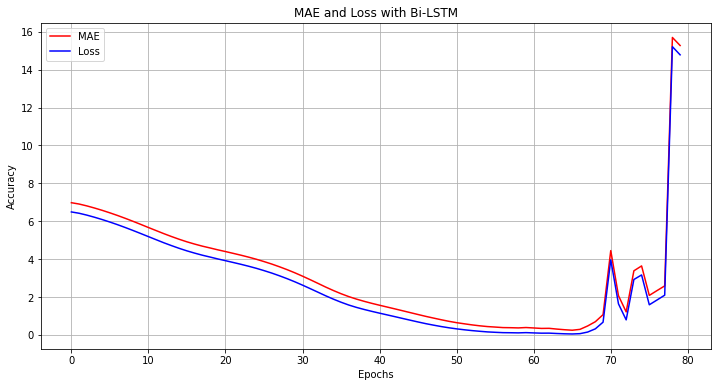

In [23]:
mae_bilstm=history_bilstm.history['mae']
loss_bilstm=history_bilstm.history['loss']

epochs=range(len(loss_bilstm)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(epochs, mae_bilstm, 'r')
ax.plot(epochs, loss_bilstm, 'b')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend(["MAE", "Loss"])
ax.grid(True)
plt.title('MAE and Loss with Bi-LSTM')

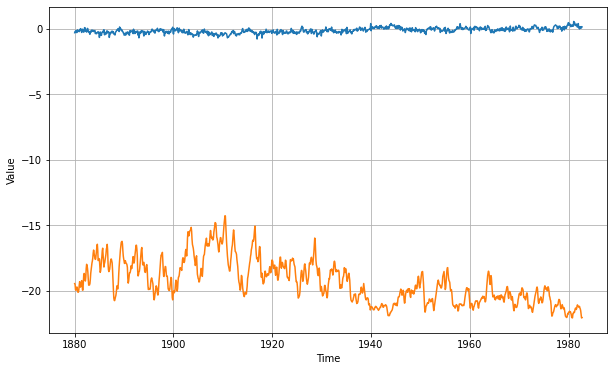

In [24]:
bilstm_forecast = model_forecast(model, series[..., np.newaxis], window_size)
bilstm_forecast = bilstm_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, bilstm_forecast)


---

# Model with a Convolution layer and some LSTM layers

Combining CNN and LSTM often give some good performances. 

## Implement the model and train it

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=32, 
                           shuffle_buffer=shuffle_buffer_size)
print(dataset)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 50)
])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


## Compile the model implemented

In [26]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

## Train the model
Please note the `verbose=0` to avoid to much printing.

In [27]:
historyCNN_LSTM = model.fit(dataset, epochs=80, 
                    callbacks=[lr_schedule], verbose=0)

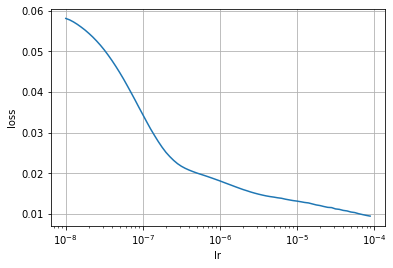

In [28]:
plt.semilogx(historyCNN_LSTM.history["lr"], historyCNN_LSTM.history["loss"])
plt.xlabel("lr");plt.ylabel("loss");plt.grid(True)
#plt.axis([1e-8, 1e-4, 0, 30])

## Plot the Mean Absolute Error (MAE) and the Loss

In [29]:
mae=historyCNN_LSTM.history['mae']
loss=historyCNN_LSTM.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(epochs, mae, 'r')
ax.plot(epochs, loss, 'b')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend(["MAE", "Loss"])
ax.grid(True)
plt.title('MAE and Loss')

Text(0.5, 1.0, 'MAE and Loss')

In [30]:
final_mae = tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()
print(f"Final MAE: {final_mae}")

Final MAE: 1.002216100692749


## Look at the forecast data

In [31]:
lstm_forecast = model_forecast(model, series[..., np.newaxis], window_size)
lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]

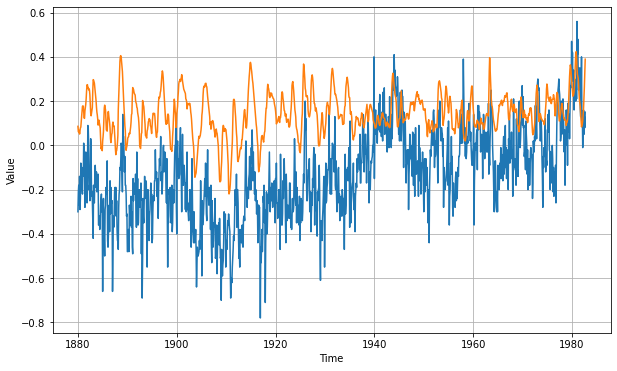

In [32]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)

# BONUS
The next few line are here to show roughtly how the data are prepared on a very small dataset
For example, use the `tf.data.Dataset` class to create some data for us we'll make a range of 10 values. 

In [33]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


Its parameters are the size of the window and how much we want to shift by each time. If we set a window size of 5 with a shift of 1 when we print it we'll see something like this, 01234, which just stops there because it's five values, then we see 12345...
Once we get towards the end of the data set we'll have less values because they just don't exist. We'll get 6789, and then 789...

In [34]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


2022-01-26 10:55:58.076426: W tensorflow/core/framework/dataset.cc:611] Input of WindowDataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


6 7 8 9 
7 8 9 
8 9 
9 


Let's edit our window a little bit, so that we have regularly sized data. We can do that with an additional parameter on the window called drop_remainder. And if we set this to true, it will truncate the data by dropping all of the remainders. Namely, this means it will only give us windows of five items. So when we print it, it will now look like this, starting at 01234 and ending at 56789. 

In [35]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


Next up is to split the data into features and labels.
For each item in the list it kind of makes sense to have all of the values but the last one to be the feature, and then the last one can be the label.
And this can be achieved with mapping, like this, where we split into everything but the last one with :-1, and then just the last one itself with -1:. Which gives us this output when we print, which now looks like a nice set of features and labels.
Typically, you would shuffle their data before training. And this is possible using the shuffle method. We call it with the buffer size of ten,
because that's the amount of data items that we have. 

In [36]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
    print(x.numpy(), y.numpy())

[2 3 4 5] [6]
[1 2 3 4] [5]
[5 6 7 8] [9]
[4 5 6 7] [8]
[0 1 2 3] [4]
[3 4 5 6] [7]


Finally, we can look at batching the data, and this is done with the batch method. It'll take a size parameter, and in this case it's 2.
So what we'll do is we'll batch the data into sets of two
We now have three batches of two data items each.

In [37]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[3 4 5 6]
 [2 3 4 5]]
y =  [[7]
 [6]]
x =  [[5 6 7 8]
 [1 2 3 4]]
y =  [[9]
 [5]]
x =  [[0 1 2 3]
 [4 5 6 7]]
y =  [[4]
 [8]]


---
<img src="./Images/IPGP_UP_couleur2.png" width="150" align="left" style="vertical-align:middle"> <h4>Earth Data Science Team - January 2022</h4>